In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

In [2]:
BASE_DIR = './' 

In [3]:
LABEL_MAP = {
    'Z': 0, 'O': 0, # Healthy subjects
    'N': 0, 'F': 0, # Epileptic subjects, but between seizures
    'S': 1          # Epileptic subjects, during a seizure
}

In [4]:
# Preprocessing Parameters
SAMPLING_RATE_HZ = 173.61        # Sampling frequency for this dataset
LOW_CUT_HZ = 0.5                 # Low frequency for bandpass filter
HIGH_CUT_HZ = 50.0               # High frequency for bandpass filter
EPOCH_DURATION_S = 1.0           # We'll cut the signals into 1-second chunks
EPOCH_SAMPLES = int(SAMPLING_RATE_HZ * EPOCH_DURATION_S) # Samples per epoch

In [5]:
print("--- Configuration Loaded ---")
print(f"Sampling Rate: {SAMPLING_RATE_HZ} Hz")
print(f"Epoch will be {EPOCH_DURATION_S} second long ({EPOCH_SAMPLES} data points)")
print("----------------------------\n")


--- Configuration Loaded ---
Sampling Rate: 173.61 Hz
Epoch will be 1.0 second long (173 data points)
----------------------------



--- Step 3: Assembling Data from All Folders ---
Processing folder 'Z' (Label: 0)... Found 100 files.
Processing folder 'O' (Label: 0)... Found 100 files.
Processing folder 'N' (Label: 0)... Found 100 files.
Processing folder 'F' (Label: 0)... Found 100 files.
Processing folder 'S' (Label: 1)... Found 100 files.

Data assembly complete.
Final shape of data (X): (11500, 173)
Final shape of labels (y): (11500,)

Class distribution in the final dataset:
  - Class 0 (Non-Seizure): 9200 epochs
  - Class 1 (Seizure):     2300 epochs
------------------------------------------------

--- Step 4: Generating Visuals for Report ---


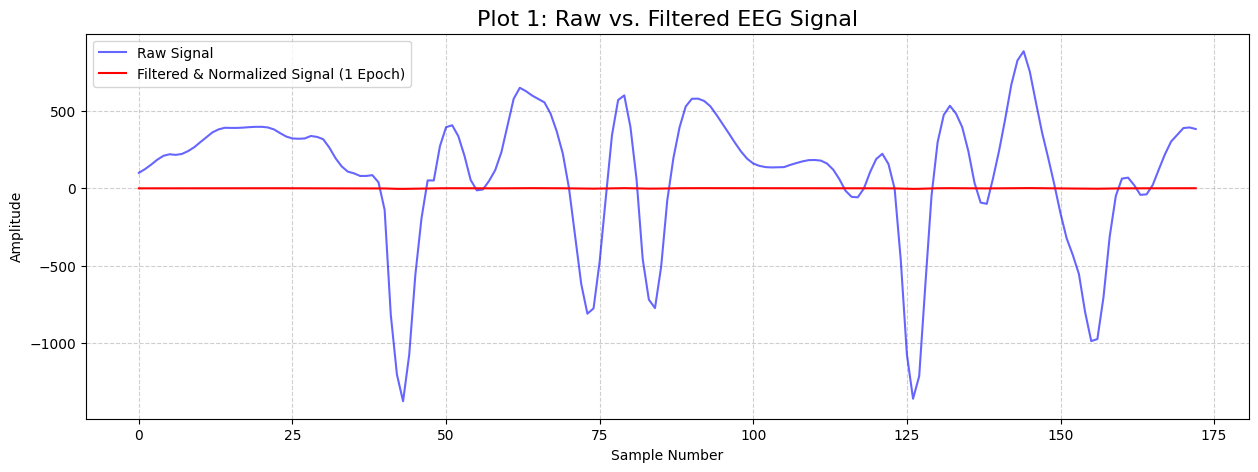

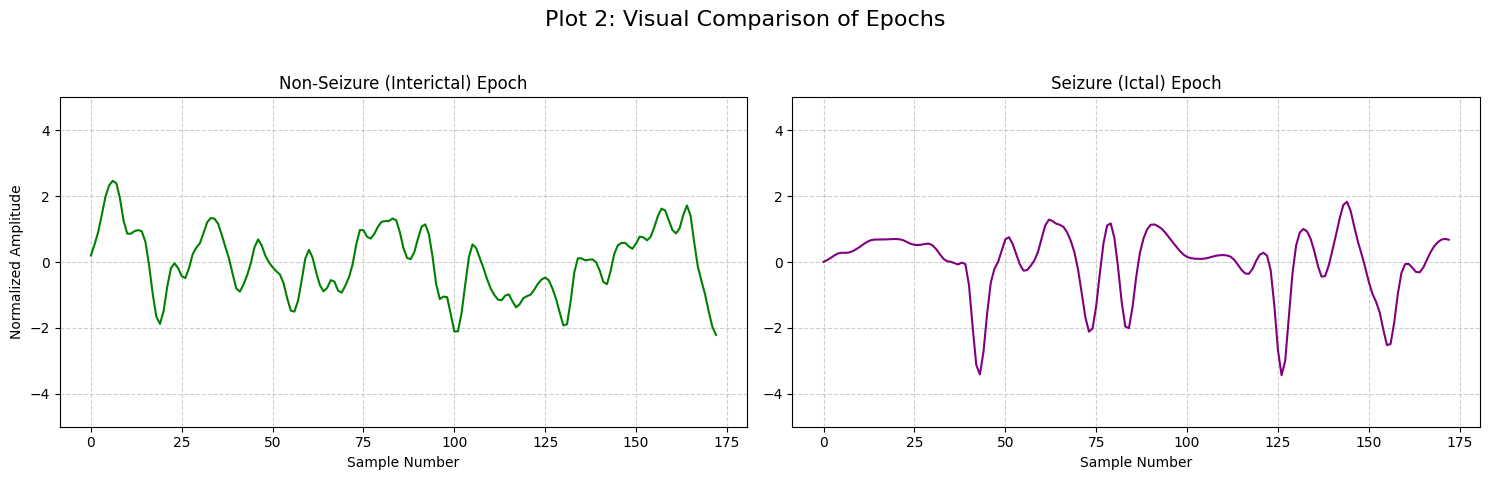

C:\Users\acer\AppData\Local\Temp\ipykernel_22824\1050480358.py:153: UserWarning: Only one segment is calculated since parameter NFFT (=256) >= signal length (=173).
  plt.specgram(non_seizure_epoch, Fs=SAMPLING_RATE_HZ, cmap='viridis')
C:\Users\acer\AppData\Local\Temp\ipykernel_22824\1050480358.py:159: UserWarning: Only one segment is calculated since parameter NFFT (=256) >= signal length (=173).
  plt.specgram(seizure_epoch, Fs=SAMPLING_RATE_HZ, cmap='viridis')


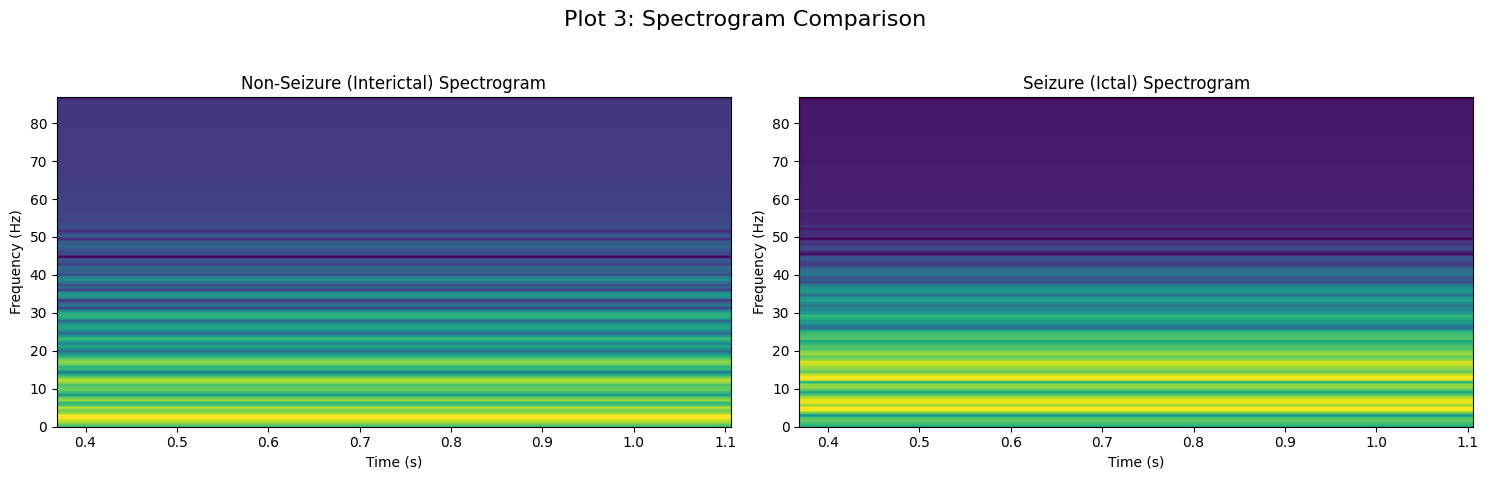

------------------------------------------------

--- End of Phase 1 ---
Data has been successfully familiarized, preprocessed, and visually inspected.
The variables `X` (data) and `y` (labels) are now ready for Phase 2.
The plots generated above should be included in your Phase 1 report.
Final dataset contains 11500 epochs, each with 173 data points.


In [10]:
def preprocess_single_eeg_file(file_path):
    """
    This function takes the path to a single EEG file and performs all
    the required preprocessing steps from Phase 1.
    
    1. Loads the data.
    2. Applies a bandpass filter.
    3. Segments the signal into epochs.
    4. Normalizes each epoch using Z-score.
    
    Returns: A NumPy array of processed epochs for that file.
    """
    # 1. Load the raw signal from the .txt file
    raw_signal = np.loadtxt(file_path)

    # 2. Apply a bandpass filter
    nyquist_freq = 0.5 * SAMPLING_RATE_HZ
    low = LOW_CUT_HZ / nyquist_freq
    high = HIGH_CUT_HZ / nyquist_freq
    b, a = butter(5, [low, high], btype='band') # 5th order Butterworth filter
    filtered_signal = filtfilt(b, a, raw_signal)

    # 3. Segment the filtered signal into epochs
    num_epochs = len(filtered_signal) // EPOCH_SAMPLES
    epochs = []
    for i in range(num_epochs):
        start = i * EPOCH_SAMPLES
        end = start + EPOCH_SAMPLES
        epoch = filtered_signal[start:end]
        epochs.append(epoch)
    
    # 4. Normalize each epoch (Z-score normalization)
    normalized_epochs = []
    for epoch in epochs:
        mean = np.mean(epoch)
        std_dev = np.std(epoch)
        # Avoid division by zero if an epoch is flat
        if std_dev > 1e-6:
            normalized_epoch = (epoch - mean) / std_dev
            normalized_epochs.append(normalized_epoch)
            
    return np.array(normalized_epochs)


# --- Step 3: Assembling Data from All Folders ---
# This is the main loop that builds your complete dataset.

X_list = []  # To store all epoch data
y_list = []  # To store all corresponding labels

print("--- Step 3: Assembling Data from All Folders ---")

for folder_name, label in LABEL_MAP.items():
    folder_path = os.path.join(BASE_DIR, folder_name)
    
    # Check if the folder actually exists
    if not os.path.isdir(folder_path):
        print(f"Warning: Folder '{folder_path}' not found. Skipping.")
        continue
        
    file_list = os.listdir(folder_path)
    print(f"Processing folder '{folder_name}' (Label: {label})... Found {len(file_list)} files.")

    for file_name in file_list:
        file_path = os.path.join(folder_path, file_name)
        
        # Process the file to get its epochs
        processed_epochs = preprocess_single_eeg_file(file_path)
        
        # Add the epochs and labels to our master lists
        if len(processed_epochs) > 0:
            for epoch in processed_epochs:
                X_list.append(epoch)
                y_list.append(label)

print("\nData assembly complete.")

# Convert lists to final NumPy arrays for machine learning
X = np.array(X_list)
y = np.array(y_list)

# Check for success
if X.shape[0] > 0:
    print(f"Final shape of data (X): {X.shape}")
    print(f"Final shape of labels (y): {y.shape}")
    
    # Print class distribution
    class_0_count = np.count_nonzero(y == 0)
    class_1_count = np.count_nonzero(y == 1)
    print("\nClass distribution in the final dataset:")
    print(f"  - Class 0 (Non-Seizure): {class_0_count} epochs")
    print(f"  - Class 1 (Seizure):     {class_1_count} epochs")
else:
    print("\nCRITICAL ERROR: No data was loaded. Please check that:")
    print("1. You have downloaded and unzipped the data.")
    print("2. The 'Z', 'O', 'N', 'F', 'S' folders are in the correct 'BASE_DIR'.")
    
print("------------------------------------------------\n")


# --- Step 4: Visual Inspection ---
# This section generates the plots required for your report.
# We will only proceed if data was loaded successfully.

if X.shape[0] > 0:
    print("--- Step 4: Generating Visuals for Report ---")

    # Plot 1: Raw vs. Filtered Signal Comparison
    sample_file_path = os.path.join(BASE_DIR, 'S', 'S001.txt') # Use a seizure file for a clear example
    raw_sample = np.loadtxt(sample_file_path)
    filtered_sample = preprocess_single_eeg_file(sample_file_path)[0] # Get the first epoch's filtered version

    plt.figure(figsize=(15, 5))
    plt.title('Plot 1: Raw vs. Filtered EEG Signal', fontsize=16)
    plt.plot(raw_sample[:EPOCH_SAMPLES], color='blue', alpha=0.6, label='Raw Signal')
    plt.plot(filtered_sample, color='red', linewidth=1.5, label='Filtered & Normalized Signal (1 Epoch)')
    plt.xlabel('Sample Number')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

    # Plot 2: Seizure vs. Non-Seizure Epoch Comparison
    seizure_epoch = X[y == 1][0]  # Get the first seizure epoch from our dataset
    non_seizure_epoch = X[y == 0][0] # Get the first non-seizure epoch

    plt.figure(figsize=(15, 5))
    plt.suptitle('Plot 2: Visual Comparison of Epochs', fontsize=16)

    plt.subplot(1, 2, 1)
    plt.plot(non_seizure_epoch, color='green')
    plt.title('Non-Seizure (Interictal) Epoch')
    plt.ylabel('Normalized Amplitude')
    plt.xlabel('Sample Number')
    plt.ylim([-5, 5]) # Lock y-axis for fair comparison
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.subplot(1, 2, 2)
    plt.plot(seizure_epoch, color='purple')
    plt.title('Seizure (Ictal) Epoch')
    plt.xlabel('Sample Number')
    plt.ylim([-5, 5]) # Lock y-axis for fair comparison
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # Plot 3: Time-Frequency Representation (Spectrogram)
    plt.figure(figsize=(15, 5))
    plt.suptitle('Plot 3: Spectrogram Comparison', fontsize=16)

    plt.subplot(1, 2, 1)
    plt.specgram(non_seizure_epoch, Fs=SAMPLING_RATE_HZ, cmap='viridis')
    plt.title('Non-Seizure (Interictal) Spectrogram')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')

    plt.subplot(1, 2, 2)
    plt.specgram(seizure_epoch, Fs=SAMPLING_RATE_HZ, cmap='viridis')
    plt.title('Seizure (Ictal) Spectrogram')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    print("------------------------------------------------\n")


# --- End of Phase 1 ---
print("--- End of Phase 1 ---")
if X.shape[0] > 0:
    print("Data has been successfully familiarized, preprocessed, and visually inspected.")
    print("The variables `X` (data) and `y` (labels) are now ready for Phase 2.")
    print("The plots generated above should be included in your Phase 1 report.")
    print(f"Final dataset contains {X.shape[0]} epochs, each with {X.shape[1]} data points.")
else:
    print("Phase 1 finished with errors. Please review the messages above.")